### Imports

In [140]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

In [141]:
sns.set(font_scale=1.5)

### Functions to Read, Train, Validate and Submit

In [142]:
# Returns the train and test datasets and a sample of the submission file
def read_data():
    train = pd.read_csv('input/train.csv')
    test = pd.read_csv('input/test.csv')
    sample = pd.read_csv('input/sample_submission.csv')
    return train, test, sample

# Returns a trainned LGBMRegressor model
def trainlgbm(xtrain, ytrain, lr=0.01, n_est=1000):
    model = lgb.LGBMRegressor(learning_rate=lr ,random_state=42, n_estimators=n_est)
    return model.fit(xtrain, ytrain)

# Validation: print mean_squared_log_error and feature importances
def score(ytrue, ypred, model=None):
    score = mean_squared_log_error(ytrue, ypred)
    print(f'The Mean Squared Log Error (MSLE) is: {score:.6f}\n')
    if model != None:
        # modelfeatures = model.feature_name_
        # print(f'The model features are {modelfeatures}')
        featureimportances = model.feature_importances_
        print(f'The features importances are {featureimportances}\n')

# Make the submission file
def make_submission(model, test, sample_submission, logtarget=True, file_name='submission.csv'):
    test_prediction = model.predict(test)
    if logtarget == True:
        test_prediction = np.exp(test_prediction)
    submission = sample_submission.copy()
    submission['SalePrice'] = test_prediction
    submission.to_csv(file_name, index=False)

### Auxiliary functions

In [143]:
# Print the complete description of the columns
def columns_description():
    description = open('input/data_description.txt')
    print(description.read())
    description.close()

# Print columns names enumerated (one per line)
def columns_names(df):
    col_enum = enumerate(df.columns)
    for i, item in col_enum:
        print(i, item)

# Print and returns the column names that have features importances > N
def fi_greater_than_N(model, train_set ,N): # train[train_numeric]
    fi_N = []
    for i in range(len(model.feature_importances_)):
        if model.feature_importances_[i] > N:
            print(f'{i}: ', list(train_set.columns)[i], model.feature_importances_[i])
            fi_N.append(list(train_set.columns)[i])
    return fi_N

### Functions for feature engineering

In [144]:
# Returns the dataframe without the categorical columns and with the encoded ones at the end
def encode_data(df, list_categorical_features):
    cat = list_categorical_features
    encoder = LabelEncoder()
    df_encoded = df[cat].apply(encoder.fit_transform)
    #new_df = df.drop([cat], axis=1)
    return df_encoded

### Functions for data analysis

In [145]:
# Prints the name of the column and the percentage of NaN values in it
def percentage_nan(df, n=10, getlist=False):
    df2 = []
    for item in df.columns:
        # True = 1 and False = 0
        df_isna = df[item].isna().astype('int')
        # Number of True's
        isna_number = sum(df_isna)
        # Percentual of True's or percentual of NaN in the column
        perc = isna_number/len(df_isna) * 100
        # Make a tuple with (column name, percentual of NaN)
        df2.append((item, perc))  
    df2 = pd.DataFrame(df2, columns=['column_name', 'percentual_of_NaN'])
    # Higher NaN percentage on top
    df2 = df2.sort_values(['percentual_of_NaN'], ascending=False, ignore_index=True)
    if getlist == False:
        print('Percentage of NaN values\n')
        print(df2.head(n))
    else:
        list_n = []
        for i in range(n):
            list_n.append(df2['column_name'][i])
        return list_n

# Transforms the values of the selected feature in sections (bins), represented by the middle value, and plots the (log) mean value of the target in that section. Usefull to see tendencies.
def mean_target_evolution(df, feature, target='SalePrice', bins=10, log_target=True):
    mean_target = []
    mean_feature = []
    edges = list(np.histogram(df[feature], bins=bins)[1])
    for i in range(len(edges)-1):
        df2 = df[(df[feature] > edges[i]) & (df[feature] < edges[i+1])]
        mean_target.append(df2[target].mean())
        mean_feature.append( (edges[i] + edges[i+1]) / 2 )
    X = mean_feature
    if log_target == True:
        Y = np.log(mean_target)
        plt.ylabel('Log of Mean-' + target);
    else:
        Y = mean_target
        plt.ylabel('Mean-' + target);
    plt.scatter(X, Y);
    plt.xlabel(feature);

# Train vs Test sets comparison:
# Calculates de relative difference (%, abs values) between some DataFrame.describe() 
# parameter (like 'mean') for each numeric column between the train and test sets.
def train_test_rel_diff(param='mean', top_n=5):
    a = train.drop(['Id', 'SalePrice'], axis=1)
    b = test.drop(['Id'], axis=1)
    ap = a.describe().loc[param]
    bp = b.describe().loc[param]
    df = []
    for col in range(a.describe().shape[1]):
        diff = ( (ap[col] - bp[col]) / ap[col] ) * 100
        df.append((a.describe().columns[col], abs(diff)))
    df = pd.DataFrame(df, columns=['Feature', 'Rel Diff']).sort_values('Rel Diff', ascending=False,                                   ignore_index=True)
    df['Rel Diff'] = df['Rel Diff'].map('{:,.2f}%'.format)
    if top_n == 0:
        print(f'Relative Diference in "{param}" (absolute values)\n')
        print(df)
    else:
        return df.head(top_n)

### Starting: Our objective is to predict the 'SalePrice' - our target

In [146]:
# Read data
train, test, sample = read_data()

### First look at the data

In [147]:
print(f'Train shape: {train.shape}\nTest shape: {test.shape}')

Train shape: (1460, 81)
Test shape: (1459, 80)


In [148]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [149]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [150]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### General train dataset visualization

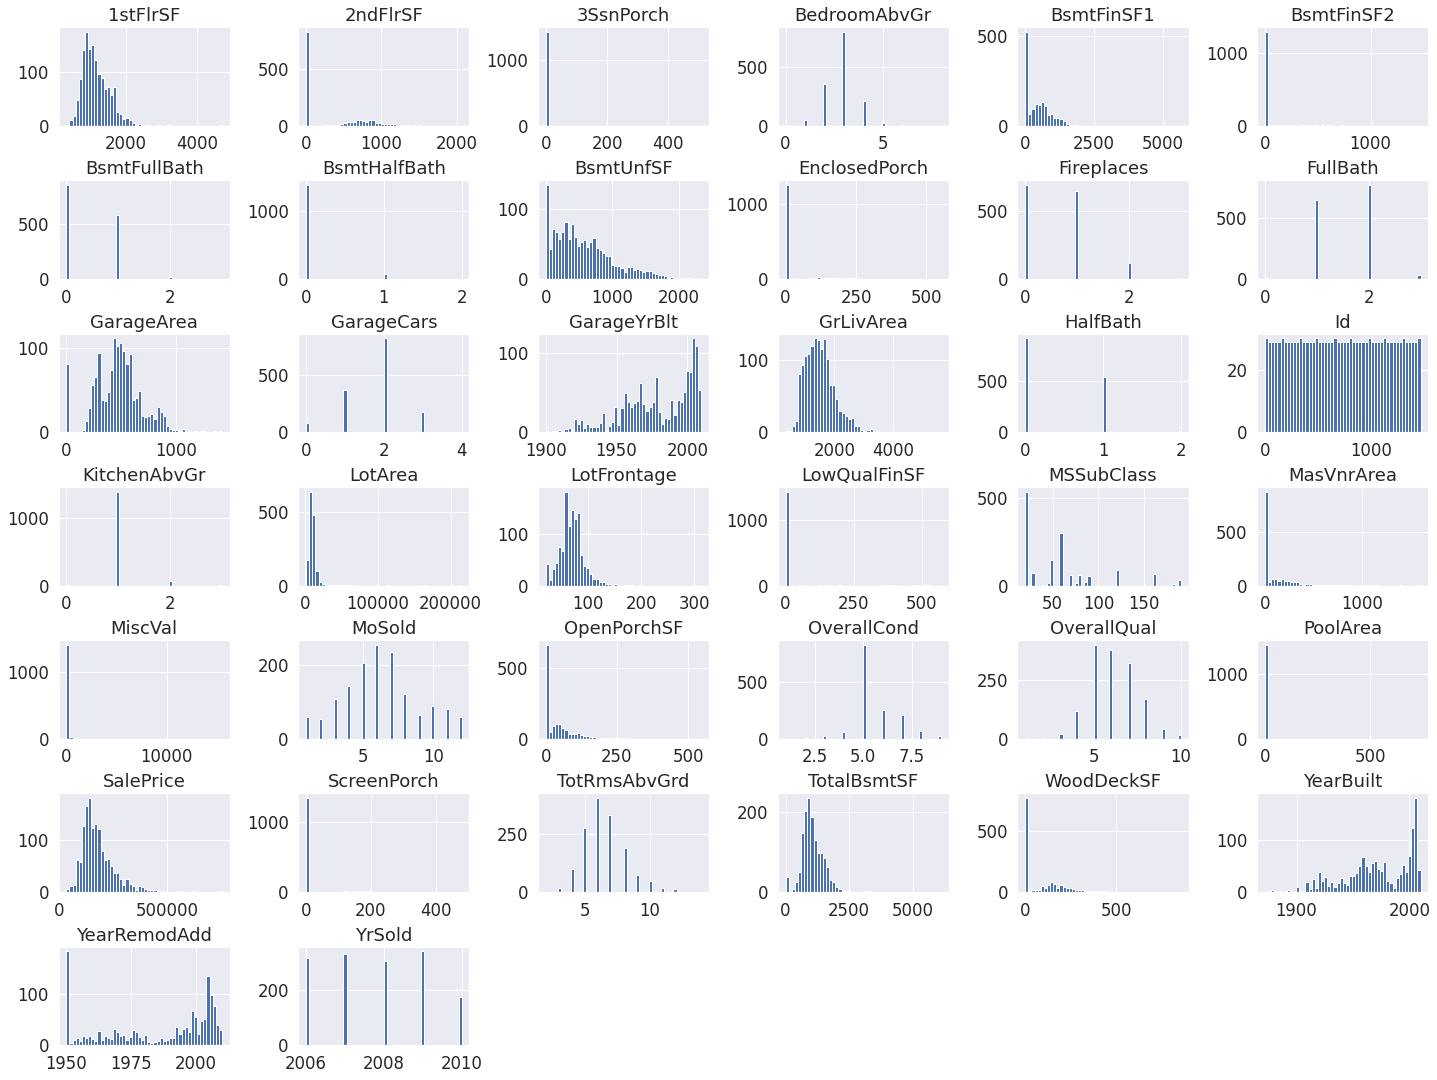

In [151]:
train.hist(bins=50, figsize=(20,15))
plt.tight_layout(pad=0.4)
plt.show()

### General test dataset visualization

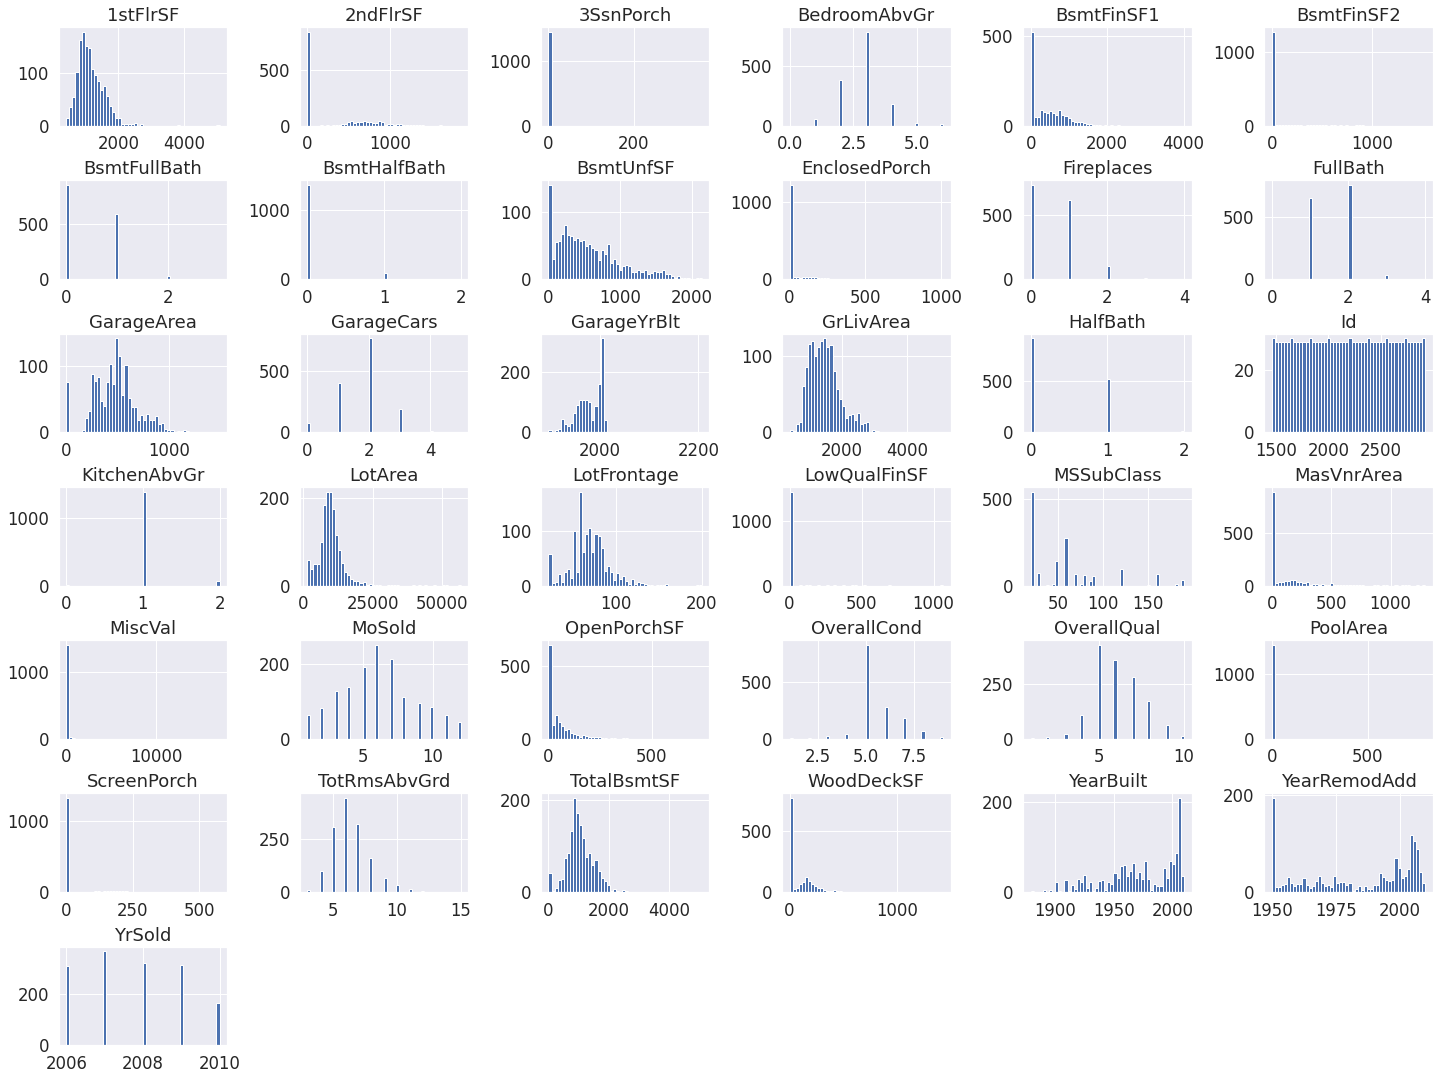

In [152]:
test.hist(bins=50, figsize=(20,15))
plt.tight_layout(pad=0.4)
plt.show()

Data looks consistent between train and test. That's good.

### Looking at the Target - 'SalePrice'

This is how much the data is skewed. And the graphs below will show the improvement that a log transformation can do for our model. Also, this shows that outliers could influence a lot the results.

In [153]:
max_mean_diff = abs(train['SalePrice'].describe().max() - train['SalePrice'].describe().mean())
min_mean_diff = abs(train['SalePrice'].describe().min() - train['SalePrice'].describe().mean())
skew = max_mean_diff - min_mean_diff
format(skew, '.2f')

'366785.33'

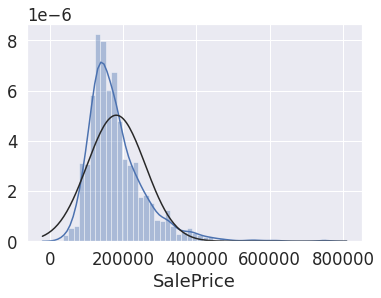

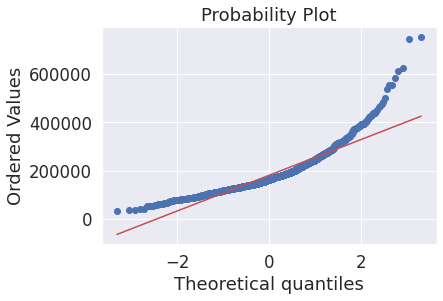

In [154]:
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt);

We could make this better with a log transformation of the SalePrice as shown in the graph below.

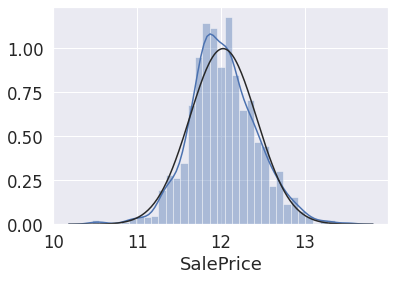

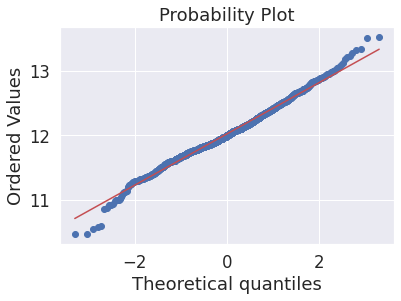

In [155]:
sns.distplot(np.log(train['SalePrice']), fit=norm);
fig = plt.figure()
res = stats.probplot(np.log(train['SalePrice']), plot=plt);

### Some direct comparison between train data and test data
For reference.


In [156]:
# How much different are the max values
top5_rd = train_test_rel_diff(param='max')
top5_rd

,Feature,Rel Diff
0,LowQualFinSF,86.01%
1,EnclosedPorch,83.33%
2,LotArea,73.70%
3,WoodDeckSF,66.16%
4,LotFrontage,36.10%


In [157]:
# How much different are the min values
top5_rd = train_test_rel_diff(param='min')
top5_rd

,Feature,Rel Diff
0,TotRmsAbvGrd,50.00%
1,1stFlrSF,21.86%
2,GrLivArea,21.86%
3,LotArea,13.08%
4,YearBuilt,0.37%


In [158]:
# How different are the means
top5_rd = train_test_rel_diff(param='mean')
top5_rd

,Feature,Rel Diff
0,3SsnPorch,47.37%
1,LowQualFinSF,39.37%
2,PoolArea,36.77%
3,MiscVal,33.75%
4,BsmtHalfBath,13.33%


### Missing Values
We can see that the train set and the test set are very alike in terms of missing values.

In [159]:
# Missing data in train set
percentage_nan(train, n=10)

Percentage of NaN values

    column_name  percentual_of_NaN
0        PoolQC          99.520548
1   MiscFeature          96.301370
2         Alley          93.767123
3         Fence          80.753425
4   FireplaceQu          47.260274
5   LotFrontage          17.739726
6   GarageYrBlt           5.547945
7    GarageCond           5.547945
8    GarageType           5.547945
9  GarageFinish           5.547945


In [160]:
# Missing data in test set
percentage_nan(test, n=10)

Percentage of NaN values

    column_name  percentual_of_NaN
0        PoolQC          99.794380
1   MiscFeature          96.504455
2         Alley          92.666210
3         Fence          80.123372
4   FireplaceQu          50.034270
5   LotFrontage          15.558602
6   GarageYrBlt           5.346127
7    GarageQual           5.346127
8  GarageFinish           5.346127
9    GarageCond           5.346127


In [161]:
# Top 5 columns with missing data in train set
too_much_nan = percentage_nan(train, n=5, getlist=True)
too_much_nan

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']

In [162]:
# Top 5 columns with missing data in test set
too_much_nan_test = percentage_nan(test, n=5, getlist=True)
too_much_nan_test

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']

### Correlations - linear dependency
Correlations indicates the importance of a feature to determine the value of the target. Not to be confused with 'model feature importance', which is the importance of each feature for the model to work.

In [163]:
# Feature correlation with the target
abs(train.corr()['SalePrice']).nlargest(5)

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64

In [164]:
# Feature correlation with the target
logtrain = train.copy()
logtrain['SalePrice'] = np.log(logtrain['SalePrice'])
abs(logtrain.corr()['SalePrice']).nlargest(5)

SalePrice      1.000000
OverallQual    0.817184
GrLivArea      0.700927
GarageCars     0.680625
GarageArea     0.650888
Name: SalePrice, dtype: float64

### Features
With the 'data_description' file we can identify in a more realistic way what feature is numeric and what feature is categorical. In this simpler model we will not create new features or drop any current feature.

In [165]:
columns_description()

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [166]:
# Train and Test Features

# Train features
train = train[[
    'Id', 
    'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
    'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
    'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
    'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
    'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition',
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
    '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal','OverallQual',
    'OverallCond', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold',
    'SalePrice'
]]

# Test features
test = test[[
    'Id', 
    'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
    'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
    'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
    'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
    'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition',
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
    '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal','OverallQual',
    'OverallCond', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold'
]]

# What are the categorical features for feature engineering --> Add new feature here [3]
cat_feat = [
    'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
    'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
    'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
    'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
    'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'
]
# What are the numerical features for feature engineering --> Add new feature here [4]
num_feat = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
    '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal','OverallQual',
    'OverallCond', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold'
]

# If a numerical feature is being used as categorical, this makes the type change to 'str'
for item in cat_feat:
    train[item] = train[item].astype('str')
    test[item] = test[item].astype('str')

### Filling Missing Values

In [167]:
# Categorical part - train and test
train[cat_feat] = train[cat_feat].fillna('missing')
test[cat_feat] = test[cat_feat].fillna('missing')
# Numerical part - train and test
train = train.fillna(0)
test = test.fillna(0)

### Enconde Categorical Data

In [168]:
# Encode train
train[cat_feat] = encode_data(train[cat_feat], cat_feat)
# Encode test
test[cat_feat] = encode_data(test, cat_feat)

### Split the Dataset for Training and Validation
We also apply a log transformation of SalePrice to make it closer to a normal distribution, making the model more accurate.

In [169]:
# Prep arguments for train, valid, split
X_train = train.drop(['Id', 'SalePrice'], axis=1)
Y_train = np.log(train['SalePrice'])

# Train, valid, split
xtrain, xvalid, ytrain, yvalid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
# test_set
test = test.drop(['Id'], axis=1)

### Model training, evaluation, test prediction and submission file
Here we use a simple LGBM model, without too much parameter optimization.

In [170]:
model = trainlgbm(xtrain, ytrain, lr=0.02, n_est=1000)

In [171]:
model.get_params

<bound method LGBMModel.get_params of LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.02, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)>

In [172]:
valid_prediction = model.predict(xvalid)
score(yvalid, valid_prediction)

The Mean Squared Log Error (MSLE) is: 0.000115



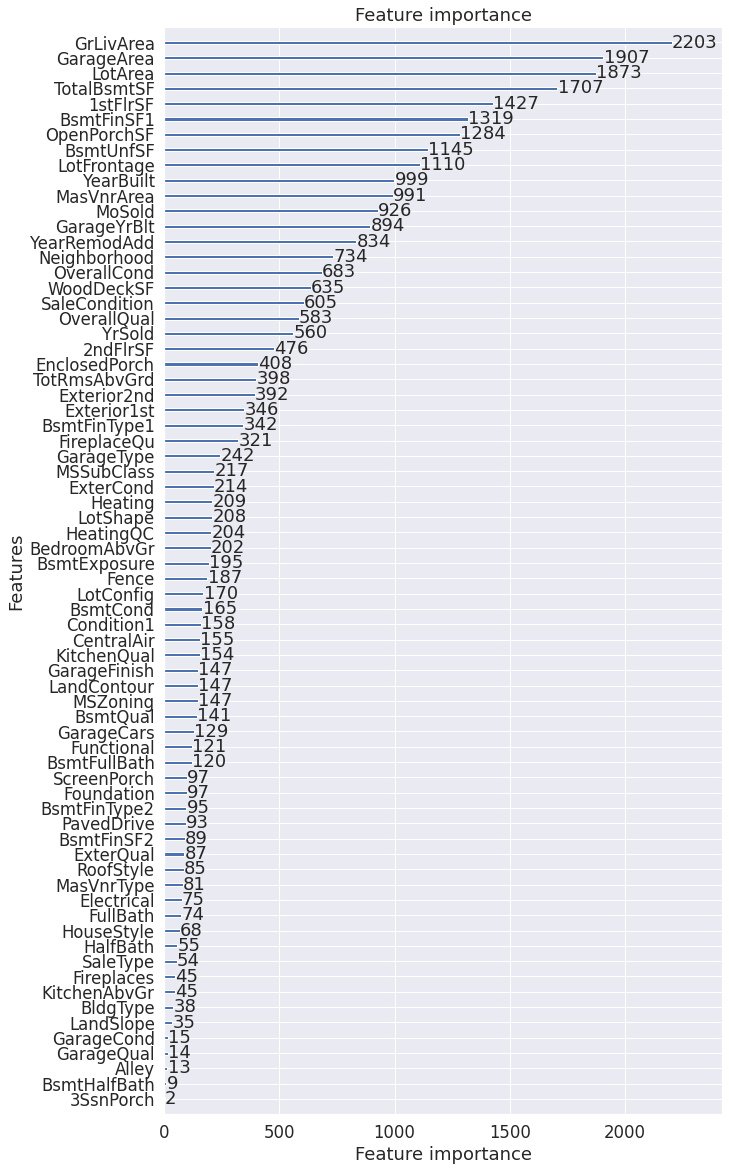

In [173]:
# How many times the feature was used by the model (ignores feature importance = 0)
lgb.plot_importance(model, figsize=(10,20), importance_type='split');

### Making the Prediction on the Testset and Creating a Submission File
Before submiting we need to do the inverse of the log in SalePrice to put it in the original format (this is built-in the function as default).

In [174]:
make_submission(model, test, sample, file_name='submission-30-07-2020.csv')